<a href="https://colab.research.google.com/github/afrojaakter/Natural-Language-Processing/blob/main/TextClassification_IMDBmovieReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Text Classification with Movie Reviews

This notebook will classify movie reviews as positive or negative using the review text. 

We'll use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) consisting of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). 50% of the dataset is for training and the rest is for testing. The train and test dataset has equal number of positive and negative reviews.

I will use [keras](https://www.tensorflow.org/guide/keras), a API to built and train model in Tensorflow and [TensorFlow Hub](https://www.tensorflow.org/hub), a library and platform for transfer learning.

In [1]:
# setup
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tdfs
import tensorflow_hub as hub
import matplotlib.pyplot as plt

print("version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "availabel" if tf.config.list_physical_devices('GPU') else "Not Available")

version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is availabel


In [2]:
# Download the IMDB dataset
train_data, test_data = tdfs.load(name = "imdb_reviews", split=["train", "test"],
                                  batch_size = -1, as_supervised = True)
train_examples, train_labels = tdfs.as_numpy(train_data)
test_examples, test_labels = tdfs.as_numpy(test_data)

In [3]:
#Explore the data
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [4]:
print("training input examples: \n{},\n\ntraining label examples: {}".format(train_examples[:5], train_labels[:5]))


training input examples: 
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbi

### Build model:

In this case I will use transfer learning, which will take care of all data preprocessing (e.g. sequence data, embedding etc)
 I will use a model from [TensorFlow Hub](https://www.tensorflow.org/hub) called [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2). nnlm-en-dim50 model splits the sentence into tokens, embeds each token and then combines the embeddings. The resulting dimensions are : `(num_examples, embedding_dimension)`.


In [26]:
# create a keras layer using Tensorflow Hub model to embed the sentences
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
#try the emdeded sentences on two train examples
print(hub_layer(train_examples[:2]))

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [33]:
# build model

model = tf.keras.Sequential()
model.add(hub_layer)  #uses saved pre-traned model to map a sentence to embedding vector
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics = [tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])


In [35]:
# creating a validation set of 10000 examples from the traning data to check the model accuracy on unseen data
val_length = 10000
x_val = train_examples[:val_length]
partial_x_train = train_examples[val_length:]

y_val = train_labels[:val_length]
partial_y_train = train_labels[val_length:]

In [36]:
#train the model
history = model.fit(partial_x_train, partial_y_train, epochs=40,
                    batch_size=512, validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 5s 67ms/step - loss: 0.6460 - accuracy: 0.6453 - val_loss: 0.5943 - val_accuracy: 0.7177
Epoch 2/40
30/30 [==============================] - 2s 57ms/step - loss: 0.5273 - accuracy: 0.7808 - val_loss: 0.4904 - val_accuracy: 0.7960
Epoch 3/40
30/30 [==============================] - 2s 58ms/step - loss: 0.4015 - accuracy: 0.8569 - val_loss: 0.4017 - val_accuracy: 0.8365
Epoch 4/40
30/30 [==============================] - 2s 58ms/step - loss: 0.2959 - accuracy: 0.8998 - val_loss: 0.3475 - val_accuracy: 0.8557
Epoch 5/40
30/30 [==============================] - 2s 58ms/step - loss: 0.2189 - accuracy: 0.9313 - val_loss: 0.3183 - val_accuracy: 0.8661
Epoch 6/40
30/30 [==============================] - 2s 56ms/step - loss: 0.1618 - accuracy: 0.9519 - val_loss: 0.3107 - val_accuracy: 0.8720
Epoch 7/40
30/30 [==============================] - 2s 58ms/step - loss: 0.1188 - accuracy: 0.9691 - val_loss: 0.3036 - val_accuracy: 0.8752
Epoch 8/40
30

In [40]:
#Evaluate the model: two values will return [loss, accuracy]
results = model.evaluate(test_data, test_labels)
print(results)

782/782 [==============================] - 4s 5ms/step - loss: 0.6944 - accuracy: 0.8453
[0.6943610310554504, 0.8452799916267395]


the model achieves 85% accuracy on test data.

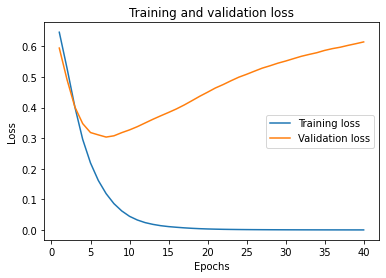

In [47]:
history_dict = history.history
history_dict.keys()

#plotting train and validation error
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

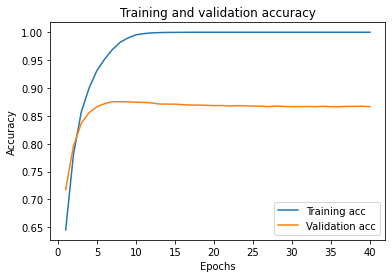

In [48]:
plt.clf()   # clear figure

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###Model 2:
Training with a larger model [google/nnlm-en-dim128-with-normalization/2 ](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2)with embedding dimension 128 instead of 50. 

In [6]:
# create a keras layer using Tensorflow Hub model to embed the sentences
model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
#try the emdeded sentences on two train examples
print(hub_layer(train_examples[:2]))

tf.Tensor(
[[ 1.15015078e+00  7.80129954e-02  9.26615447e-02  2.83361465e-01
   9.67164431e-03 -1.49186030e-01  3.35665703e-01 -3.50244790e-01
  -8.28830525e-03 -1.87713988e-02 -3.33069712e-02 -6.33094192e-01
  -3.75421166e-01 -2.77732819e-01 -9.66175571e-02  1.72553658e-01
  -1.33676559e-01  3.80765833e-02 -2.75138170e-01  4.94762301e-01
   3.93051691e-02  1.34496242e-01 -2.70728201e-01  1.78942848e-02
  -2.41071597e-01  2.71089897e-02  1.02333426e-01 -1.06628530e-01
   5.24298586e-02  1.19170524e-01 -6.67077769e-03  3.39231491e-01
   1.13014966e-01  1.06842607e-01  3.91571254e-01 -1.89536318e-01
  -1.74000308e-01 -1.06444173e-01 -1.34200469e-01  1.73583925e-01
  -2.77695030e-01 -4.33591381e-02 -3.91500629e-02 -1.98340908e-01
   2.74854768e-02  2.76703000e-01  1.40702859e-01 -3.14256102e-01
   2.47569364e-02 -1.67308271e-01  8.21740329e-02 -9.56841931e-02
  -2.57335782e-01  3.72914702e-01 -2.21059933e-01 -2.14436874e-01
  -5.83256148e-02  1.50036871e-01 -1.67723849e-01 -8.02809969e-02

In [7]:
# build model

model = tf.keras.Sequential()
model.add(hub_layer)  #uses saved pre-traned model to map a sentence to embedding vector
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics = [tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

# creating a validation set of 10000 examples from the traning data to check the model accuracy on unseen data
val_length = 10000
x_val = train_examples[:val_length]
partial_x_train = train_examples[val_length:]

y_val = train_labels[:val_length]
partial_y_train = train_labels[val_length:]

#train the model
history = model.fit(partial_x_train, partial_y_train, epochs=10,
                    batch_size=512, validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 4s 111ms/step - loss: 0.6138 - accuracy: 0.7314 - val_loss: 0.5189 - val_accuracy: 0.8075
Epoch 2/10
30/30 [==============================] - 3s 109ms/step - loss: 0.4149 - accuracy: 0.8587 - val_loss: 0.3639 - val_accuracy: 0.8626
Epoch 3/10
30/30 [==============================] - 3s 106ms/step - loss: 0.2636 - accuracy: 0.9139 - val_loss: 0.2948 - val_accuracy: 0.8832
Epoch 4/10
30/30 [==============================] - 3s 108ms/step - loss: 0.1773 - accuracy: 0.9440 - val_loss: 0.2674 - val_accuracy: 0.8931
Epoch 5/10
30/30 [==============================] - 3s 106ms/step - loss: 0.1196 - accuracy: 0.9678 - val_loss: 0.2652 - val_accuracy: 0.8924
Epoch 6/10
30/30 [==============================] - 3s 106ms/step - loss: 0.0795 - accuracy: 0.9828 - val_loss: 0.2598 - val_accuracy: 0.8965
Epoch 7/10
30/30 [==============================] - 3s 107ms/step - loss: 0.0511 - accuracy: 0.9913 - val_loss: 0.2672 - val_accuracy: 0.8963
Epoch 

In [9]:
#Evaluate the model: two values will return [loss, accuracy]
results = model.evaluate(test_data, test_labels)
print(results)

782/782 [==============================] - 4s 6ms/step - loss: 0.3706 - accuracy: 0.8690
[0.3706367611885071, 0.8690000176429749]


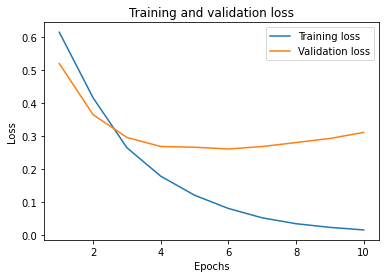

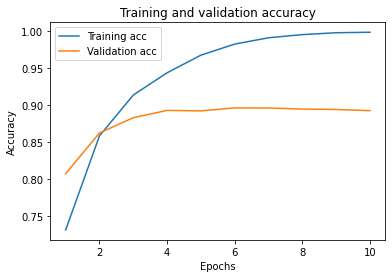

In [10]:
history_dict = history.history
history_dict.keys()

#plotting train and validation error
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Reference: https://www.tensorflow.org/hub/tutorials/tf2_text_classification